# Курсовой проект
### Постановка задачи
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

**Целевая метрика**

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Решение должно содержать:

- Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
- Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
- Рекомендации для файла с кодом (ipynb)
- Файл должен содержать заголовки и комментарии (markdown)
- Повторяющиеся операции лучше оформлять в виде функций
- Не делать вывод большого количества строк таблиц (5-10 достаточно)
- По возможности добавлять графики, описывающие данные (около 3-5)
- Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
- Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
- Весь проект должен быть в одном скрипте (файл ipynb).
- Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

#### Примерное описание этапов выполнения курсового проекта
#### Построение модели классификации

- Обзор обучающего датасета
- Обработка выбросов
- Обработка пропусков
- Анализ данных
- Отбор признаков
- Балансировка классов
- Подбор моделей, получение бейзлана
- Выбор наилучшей модели, настройка гиперпараметров
- Проверка качества, борьба с переобучением
- Интерпретация результатов
- Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
- Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
- Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
- Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных
**Описание датасета**

- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, GridSearchCV
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import lightgbm as lgbm 
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE

C:\Users\lenas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Загрузка и обзор тренировочного и тестового датасетов

In [2]:
# Тренировочный датасет

train = pd.read_csv('course_project_train.csv')

print('DataSet Info')
print('=' * 60)
print(train.info())
print('=' * 60)
print('=' * 60)
print('=' * 60)

print('DataSet Stats')
print('=' * 60)
print(train.describe())

print('=' * 60)
print('=' * 60)
print('=' * 60)

print('Missing Values')
print('=' * 60)
print(train.isna().sum())

train.head()

DataSet Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   flo

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Краткие выводы**

Целевая переменная - Credit Default

**DataSet Info:**

Необходимо будет выполнить приведение типа к числовому у признака **Years in current job**

Выделим предварительно категориальные признаки:
1. Home Ownership
2. Purpose
3. Term

**DataSet Stats:**

- очень большие значение в признаках: Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance. Их надо проанализировать
- вероятно будут выбросы

**Missing Values:**

В пяти признаках есть пропуски:
- Annual income
- Years in current job
- Months since last delinquent
- Bankruptcies 
- Credit Score 

In [3]:
# Тестовый датасет

test = pd.read_csv('course_project_test.csv')

print('DataSet Info')
print('=' * 60)
print(test.info())
print('=' * 60)
print('=' * 60)
print('=' * 60)

print('DataSet Stats')
print('=' * 60)
print(test.describe())

print('=' * 60)
print('=' * 60)
print('=' * 60)

print('Missing Values')
print('=' * 60)
print(test.isna().sum())

test.head()

DataSet Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   flo

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Краткие выводы**

**DataSet Info:**

Необходимо будет выполнить приведение типа к числовому у признака **Years in current job**

Выделим предварительно категориальные признаки (некоторые из них нужно будет привести к нужному типу object):
1. Home Ownership
2. Purpose
3. Term

**DataSet Stats:**

- очень большие значение в признаках: Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance. Их надо проанализировать
- отличные от тестового датасета данные в признаке Tax liens (возможно, это и не категориальный признак).
- Number of Credit Problems тоже самое. Квантили везде по нулям, но максимальное значение равно 7
- необходимо будет также обработать выбросы

**Missing Values:**

В пяти признаках есть пропуски:
- Annual income
- Years in current job
- Months since last delinquent
- Bankruptcies 
- Credit Score 

## ЭТАП 1. ПРЕДОБРАБОТКА ДАННЫХ

### Приведение типов

Приведем к числовому типу признак Years in current job

In [4]:
train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [5]:
def types_prep(df):
    
    # делаем преобразование типа для признака Years in current job
    level_map = {'< 1 year': 0, 
             '1 year': 1,
             '2 years': 2,
             '3 years': 3,
             '4 years': 4,
             '5 years': 5,
             '6 years': 6,
             '7 years': 7,
             '8 years': 8,
             '9 years': 9,
             '10+ years': 10}

    df['Years in current job'] = df['Years in current job'].map(level_map)
    
types_prep(train)
types_prep(test)

print(train.dtypes)
print('*' * 60)
print(test.dtypes)

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object
************************************************************
Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maxim

### Обработка пропусков

<AxesSubplot:>

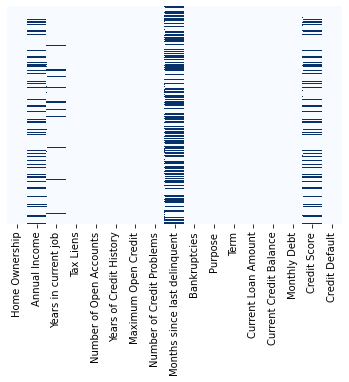

In [6]:
# Визуализируем пропуски на тренировочном датасете

sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [7]:
train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Интересное совпадение - при пропусках в "Annual Income" имеется ровно такое же количество пропусков в признаке "Credit Score"

Credit score. Кредитный скоринг (от англ. score «оценка»; в т.ч. гл.) — система оценки кредитоспособности (кредитных рисков) лица, основанная на численных статистических методах. Как правило, используется в потребительском (магазинном) экспресс-кредитовании на небольшие суммы.

На основе пропусков можно сделать вывод, что без информации о годовой доходе мы не можем оценить кредитоспособность клиента.

<AxesSubplot:>

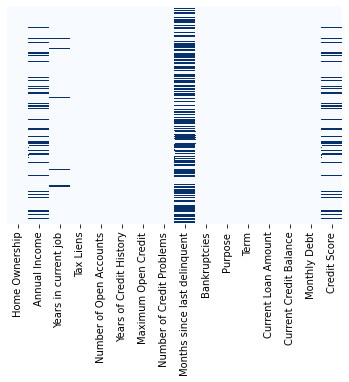

In [8]:
# Визуализируем пропуски на тестовом датасете

sns.heatmap(test.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [9]:
test.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [10]:
def clean_NAN(df):
    df['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
    df['Credit Score'].fillna(train['Credit Score'].median(), inplace=True)
    df['Years in current job'].fillna(train['Years in current job'].median(), inplace=True)
    df['Bankruptcies'].fillna(train['Bankruptcies'].median(), inplace=True)
    df['Months since last delinquent'].fillna(train['Months since last delinquent'].median(), inplace=True)

clean_NAN(train)
clean_NAN(test)

## ЭТАП 2. ВИЗУАЛИЗАЦИЯ ДАННЫХ

#### Целевая переменная

In [11]:
# разобьем выборку на тех, кто просрочил и на тех, кто заплатил вовремя

no_default = train[train['Credit Default'] == 0]
default = train[train['Credit Default'] == 1]

In [12]:
# Посчитаем, сколько человек и в каком процентном соотношении неоплатили кредит на тренировочном датасете

print('Всего = ', len(train), 'клиентов')
print('Количество клиентов, просрочившие платеж по кредиту = ', len(default))
print('% клиентов просрочившие платеж по кредиту = ', 1.*len(default)/len(train) * 100, '%')

print('Количество клиентов, заплативших вовремя = ', len(no_default))
print('% клиентов, заплативших вовремя = ', 1.*len(no_default)/len(train) * 100, '%')

Всего =  7500 клиентов
Количество клиентов, просрочившие платеж по кредиту =  2113
% клиентов просрочившие платеж по кредиту =  28.173333333333332 %
Количество клиентов, заплативших вовремя =  5387
% клиентов, заплативших вовремя =  71.82666666666667 %


Мы имеет дело с несбалансированным набором данных

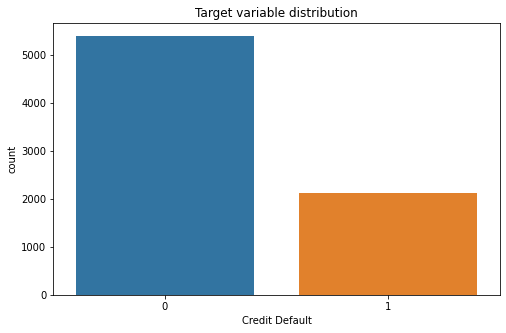

In [13]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=train)

plt.title('Target variable distribution')
plt.show()

#### Распределение категориальных признаков в зависимости от целевой переменной

<AxesSubplot:xlabel='Term', ylabel='count'>

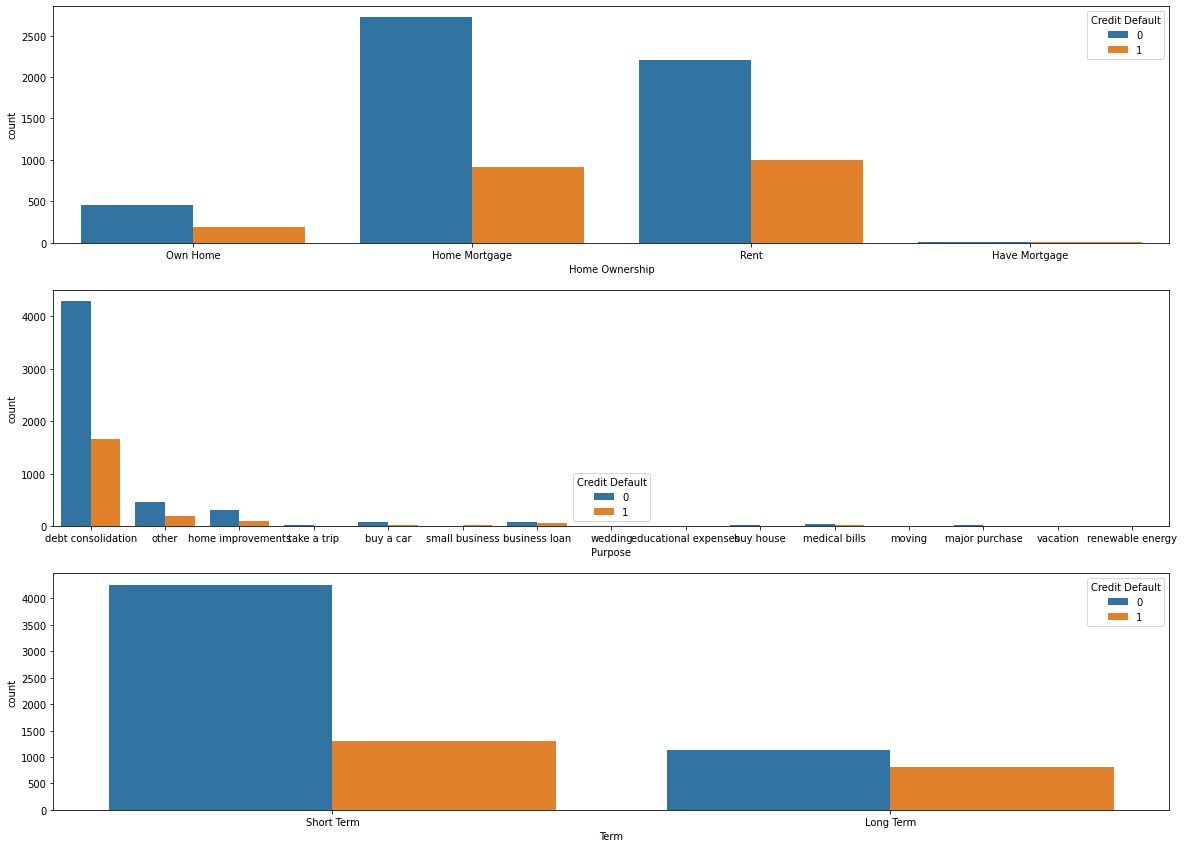

In [14]:
plt.figure(figsize=(20, 20))

plt.subplot(411)
sns.countplot(x='Home Ownership', hue='Credit Default', data=train)

plt.subplot(412)
sns.countplot(x='Purpose', hue='Credit Default', data=train)

plt.subplot(413)
sns.countplot(x='Term', hue='Credit Default', data=train)

Большее количество клиентов берут кредит на короткий срок. И большая часть платит вовремя. Клиенты, которые берут кредит на длительный срок, имеют гораздо меньшую разницу по частоте вылаты/не выплаты суммы в срок. 

На этом основании можно сформировать гипотезу, что люди, берущие кредит на короткий срок с большей вероятностью выплатят сумму вовремя,чем клиенты, берущие кредит на длительный срок.

В признаке Purpose очень много редких категорий. 

In [15]:
# В признаке Purpose оставим только "debt consolidation", "other", "home improvement", остальные объединим в одну
def purpose_preprocess(df):
    important_purpose = ['debt consolidation', 'other', 'home improvements']
    df.loc[~df['Purpose'].isin(important_purpose), 'Purpose'] = 'rest'
    
purpose_preprocess(train)
purpose_preprocess(test)

### Создание новых признаков

<AxesSubplot:>

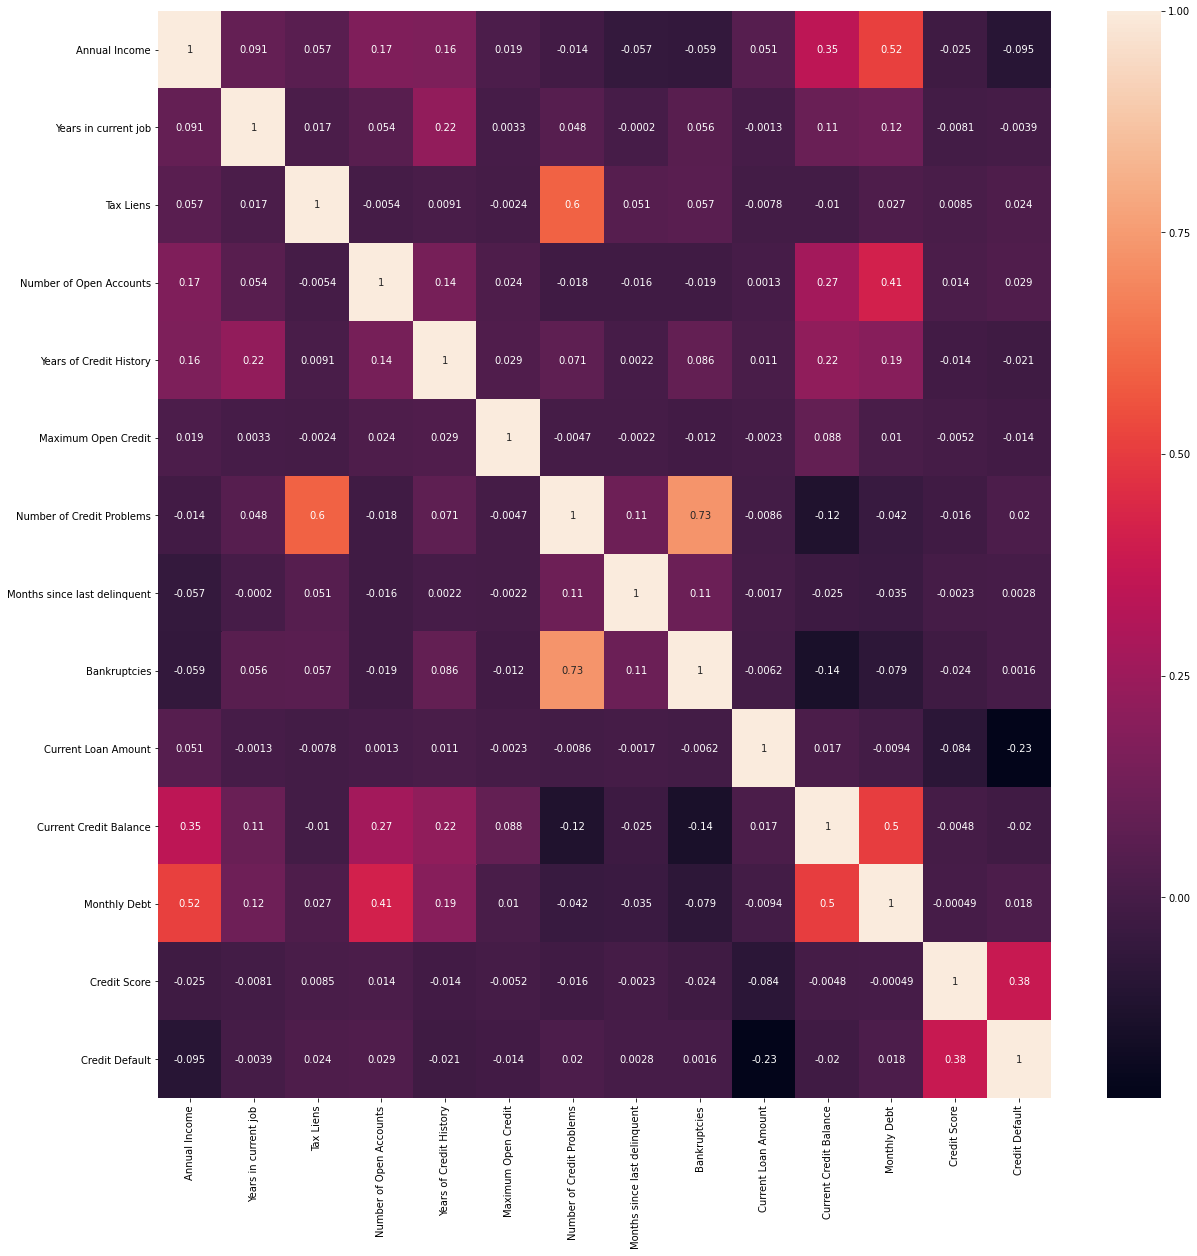

In [16]:
correlations = train.corr()
f, ax = plt.subplots(figsize = (20, 20))

sns.heatmap(correlations, annot = True)

Видны высокие корреляции между признаками:
- Number of credit problems & Tax Liens
- Current credit balance & Maximum Open Credit
- Bunkruptcies & Number of credit problems
- Monthly Debt & Annual Income
- Monthly Debt & Current credit balance

Признак Bankruptcies можно удалить, т.к. он сильно коррелирует с признаком Number of Credit Problems

train_df = train_df.drop('Bankruptcies', axis=1)
test_df = test_df.drop('Bankruptcies', axis=1)

In [17]:
def code_mean(df, cat_feat, num_feat):
    """
    Функция создает новый столбец с медианным значением в категории одного признака
    
    """
    return (df[cat_feat].map(train.groupby(cat_feat)[num_feat].median())) #сделала медианное значение от тренировочного датасета

def new_feat(df):

    # признак средний доход в зависимости от владения домом/квартирой
    df['Home Ownership mean Annual Income'] = code_mean(df, 'Home Ownership', 'Annual Income')

    # признак средняя месячная сумма платежа в зависимости от срока кредита
    df['Term mean Monthly Debt'] = code_mean(df, 'Term', 'Monthly Debt')

    # признак средняя текущая сумма кредита в зависимости от цели кредита
    df['Purpose mean Current Loan Amount'] = code_mean(df, 'Purpose', 'Current Loan Amount')

    # признак средняя текущая сумма кредита в зависимости от срока кредита
    df['Term mean Current Loan Amount'] = code_mean(df, 'Term', 'Current Loan Amount')

In [18]:
new_feat(train)
new_feat(test)

In [19]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership mean Annual Income,Term mean Monthly Debt,Purpose mean Current Loan Amount,Term mean Current Loan Amount
0,Own Home,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,Short Term,99999999.0,47386.0,7914.0,749.0,0,1147448.0,15004.0,324104.0,250118.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,Long Term,264968.0,394972.0,18373.0,737.0,1,1147448.0,19175.5,324104.0,437063.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,Short Term,99999999.0,308389.0,13651.0,742.0,0,1168519.0,15004.0,324104.0,250118.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,1147448.0,15004.0,324104.0,250118.0
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,1168386.0,15004.0,324104.0,250118.0


#### Корреляции с целевым признаком

In [20]:
train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership mean Annual Income',
       'Term mean Monthly Debt', 'Purpose mean Current Loan Amount',
       'Term mean Current Loan Amount'],
      dtype='object')

In [21]:
# Поставила Credit Default на последнее место для удобства

train = train[['Annual Income',
 'Years in current job',
 'Number of Open Accounts',
 'Years of Credit History',
 'Months since last delinquent',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership',
 'Tax Liens',
 'Purpose',
 'Term',
 'Home Ownership mean Annual Income',
 'Term mean Monthly Debt',
 'Purpose mean Current Loan Amount',
 'Term mean Current Loan Amount',
 'Credit Default']]

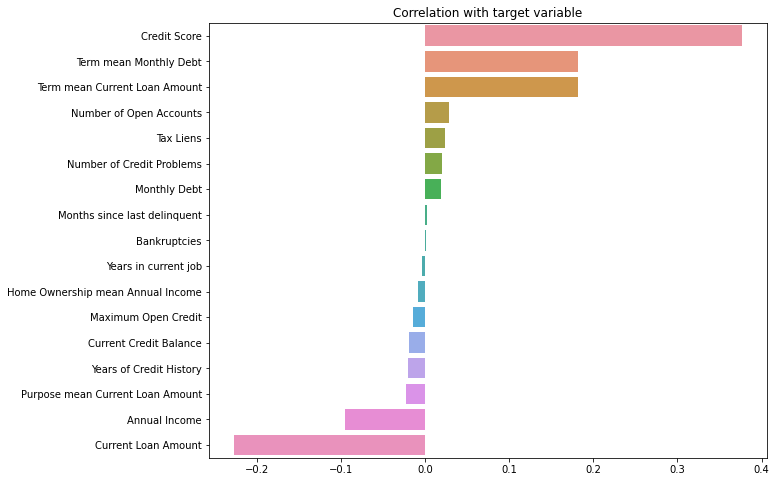

In [22]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Наиболее выраженные корреляции с признаками: 
- Term mean Monthly Debt
- Term mean Current Loan Amount
- Current Loan Amount
- Maximum Open Credit
- Annual Income
- Credit Score

#### Кодирование категориальных признаков

In [24]:
train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [25]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
rest                   479
home improvements      412
Name: Purpose, dtype: int64

In [26]:
train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [27]:
def cat_feat_prep(df):
    
    # делаем преобразование типа для признака Home Ownership
    level_map_ho = {'Home Mortgage': 0, 'Rent': 1, 'Own Home': 2, 'Have Mortgage': 3}
    df['Home Ownership'] = df['Home Ownership'].map(level_map_ho)
    
    # делаем преобразование типа для признака Purpose
    level_map_p = {'debt consolidation': 0, 'other': 1, 'rest': 2, 'home improvements': 3}
    df['Purpose'] = df['Purpose'].map(level_map_p)
    
    # делаем преобразование типа для признака Term
    level_map_t = {'Short Term': 0, 'Long Term': 1}
    df['Term'] = df['Term'].map(level_map_t)    

In [28]:
cat_feat_prep(train)
cat_feat_prep(test)

train.head()

,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Months since last delinquent,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Credit Score,Home Ownership,Tax Liens,Purpose,Term,Home Ownership mean Annual Income,Term mean Monthly Debt,Purpose mean Current Loan Amount,Term mean Current Loan Amount,Credit Default
0,482087.0,6.0,11.0,26.3,32.0,685960.0,1.0,1.0,99999999.0,47386.0,...,749.0,2,0.0,0,0,1147448.0,15004.0,324104.0,250118.0,0
1,1025487.0,10.0,15.0,15.3,32.0,1181730.0,0.0,0.0,264968.0,394972.0,...,737.0,2,0.0,0,1,1147448.0,19175.5,324104.0,437063.0,1
2,751412.0,8.0,11.0,35.0,32.0,1182434.0,0.0,0.0,99999999.0,308389.0,...,742.0,0,0.0,0,0,1168519.0,15004.0,324104.0,250118.0,0
3,805068.0,6.0,8.0,22.5,32.0,147400.0,1.0,1.0,121396.0,95855.0,...,694.0,2,0.0,0,0,1147448.0,15004.0,324104.0,250118.0,0
4,776264.0,8.0,13.0,13.6,32.0,385836.0,1.0,0.0,125840.0,93309.0,...,719.0,1,0.0,0,0,1168386.0,15004.0,324104.0,250118.0,0


#### Разбиваем выборку на train и valid 

In [29]:
X = train.drop('Credit Default', axis=1)
y = train['Credit Default']

In [30]:
X_test = test.copy()

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной

In [32]:
# Oversampling

sm = SMOTE(random_state = 2)

X_train, y_train = sm.fit_sample(X_train, y_train)

### LightGBM

In [33]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [34]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [35]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [36]:
model_lgbm = lgbm.LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=40, reg_alpha=10, 
                                 random_state=21, num_leaves=10)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      3771
           1       0.88      0.73      0.80      3771

    accuracy                           0.82      7542
   macro avg       0.83      0.82      0.81      7542
weighted avg       0.83      0.82      0.81      7542

TEST

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1616
           1       0.58      0.41      0.48       634

    accuracy                           0.75      2250
   macro avg       0.69      0.65      0.66      2250
weighted avg       0.73      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1426  190
1                373  261


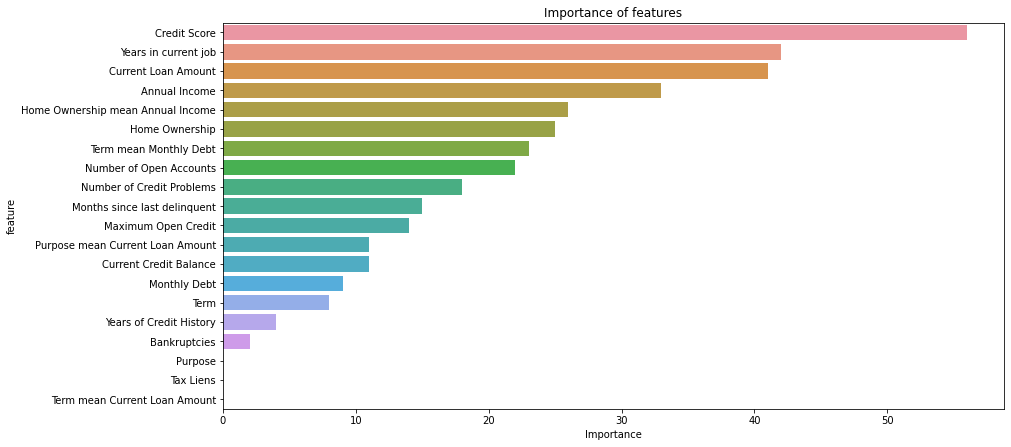

In [37]:
important_features_top = show_feature_importances(X_train.columns, 
                                                 model_lgbm.feature_importances_, 
                                                  get_top=15)

### Финальная модель<a class="anchor" id="final_model"></a>

In [38]:
final_model = lgbm.LGBMClassifier(max_depth=8, learning_rate=0.1, n_estimators=10, reg_alpha=0.1, 
                                 random_state=21, num_leaves=20, num_iterations=20, bagging_fraction=0.5,
                                 feature_fraction=0.6)
                                 
final_model.fit(X[important_features_top], y)

y_train_pred = final_model.predict(X[important_features_top])
y_valid_pred = final_model.predict(X_valid[important_features_top])
y_valid_pred_probs = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y, y_train_pred, y_valid, y_valid_pred)

C:\Users\lenas\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
TRAIN

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      5387
           1       0.96      0.27      0.42      2113

    accuracy                           0.79      7500
   macro avg       0.87      0.63      0.64      7500
weighted avg       0.83      0.79      0.74      7500

TEST

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1616
           1       0.94      0.26      0.41       634

    accuracy                           0.79      2250
   macro avg       0.86      0.63      0.64      2250
weighted avg       0.82      0.79      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1605  

C:\Users\lenas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


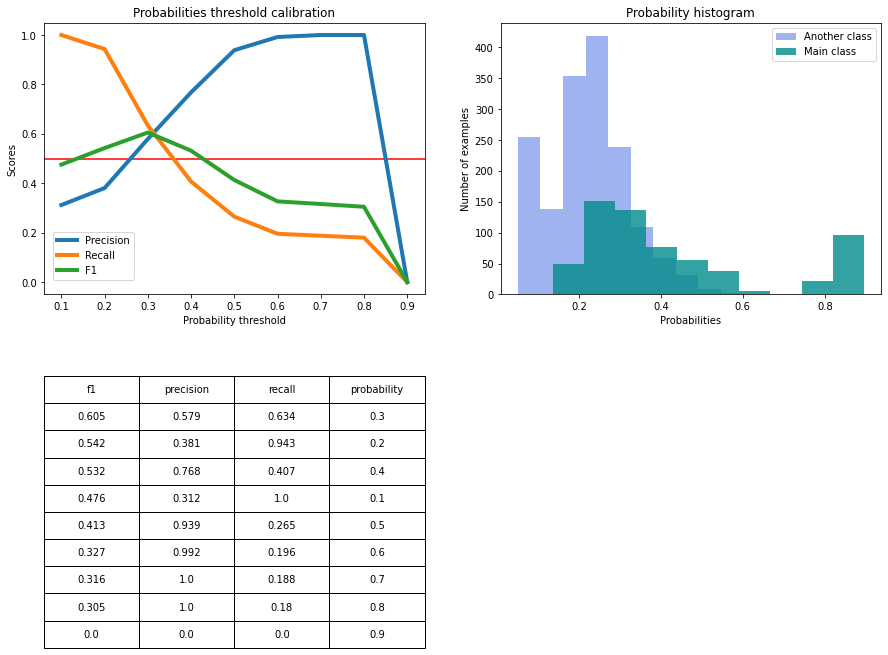

In [39]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

Подберем наилучший порог вероятности отнесения к целевому классу

In [40]:
y_valid_labels = np.array(y_valid_pred_probs[:, 1] > 0.30, dtype=int)
get_classification_report(y, y_train_pred, y_valid, y_valid_labels)

TRAIN

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      5387
           1       0.96      0.27      0.42      2113

    accuracy                           0.79      7500
   macro avg       0.87      0.63      0.64      7500
weighted avg       0.83      0.79      0.74      7500

TEST

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1616
           1       0.58      0.63      0.61       634

    accuracy                           0.77      2250
   macro avg       0.72      0.73      0.72      2250
weighted avg       0.77      0.77      0.77      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1324  292
1                232  402


### Предсказание для тестового датасета и сохранение результатов

In [41]:
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

In [42]:
y_test_pred = np.array(y_test_pred_probs[:, 1] > 0.30, dtype=int)

In [43]:
X_test['Prediction'] = y_test_pred

In [44]:
X_test['Prediction'].value_counts()

0    1746
1     754
Name: Prediction, dtype: int64

In [45]:
X_test['Prediction'].to_csv('ElenaShcherbakova_predictions.csv')